# Predicting House Prices: Model Training and Testing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor

In [2]:
df = pd.read_csv('cleaned_data.csv') # import cleaned data 
# check data information
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17947 entries, 0 to 17946
Data columns (total 76 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Net_Metrekare                         17947 non-null  int64  
 1   Oda_Sayısı                            17947 non-null  float64
 2   Bulunduğu_Kat                         17947 non-null  int64  
 3   Binanın_Yaşı                          17947 non-null  int64  
 4   Fiyat                                 17947 non-null  float64
 5   Binanın_Kat_Sayısı                    17947 non-null  int64  
 6   Banyo_Sayısı                          17947 non-null  float64
 7   Isıtma_Tipi_Doğalgaz Sobalı           17947 non-null  bool   
 8   Isıtma_Tipi_Güneş Enerjisi            17947 non-null  bool   
 9   Isıtma_Tipi_Isıtma Yok                17947 non-null  bool   
 10  Isıtma_Tipi_Jeotermal                 17947 non-null  bool   
 11  Isıtma_Tipi_Kat

## splitting data into train and test sets:
* we will use 80% of the data for training and 20% for testing.
* after that, we log transform our data so we can have less variability in the data.
* then we scale our data so it is normalized and ready for the model prediction.

In [3]:
# We drop 'Fiyat' (target) AND 'Banyo_Sayısı' (to make it ineffective)
X = df.drop(['Fiyat', 'Banyo_Sayısı'], axis=1)
y = df['Fiyat'] # target  

# 2. Train-Test Split (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Log transform target
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

scale_cols=['Net_Metrekare','Oda_Sayısı', 'Bulunduğu_Kat',
              'Binanın_Yaşı', 'Binanın_Kat_Sayısı']
scaler = StandardScaler()
X_train[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_test[scale_cols] = scaler.transform(X_test[scale_cols])
print(f"Training Shape: {X_train.shape}")
print(f"Testing Shape: {X_test.shape}")

Training Shape: (14357, 74)
Testing Shape: (3590, 74)


## Testing models :

In [4]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
    "SVR": SVR()
} # Dictionary of models so we can loop through them and cleanly find the best model

In [5]:

# lists containing the metrics and we can use that for pd table comparison 
rmse_values = [] 
r2_values = []
mae_values = []
mape_values = []
cv_scores = []

for model_name, model in models.items():
    # 1. Train and Predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Inverse transform for metrics
    y_test_orig = np.expm1(y_test)
    y_pred_orig = np.expm1(y_pred)
    
    # 2. Calculate Standard Metrics
    rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
    r2 = r2_score(y_test_orig, y_pred_orig)
    mae = mean_absolute_error(y_test_orig, y_pred_orig)
    
    # 3. Calculate MAPE (Mean Absolute Percentage Error)
    # Handling division by zero just in case, though unlikely in house prices
    mask = y_test_orig != 0
    mape = np.mean(np.abs((y_test_orig[mask] - y_pred_orig[mask]) / y_test_orig[mask])) * 100
    
    # 4. Cross-Validation (5-Fold)
    # Note: 'neg_root_mean_squared_error' is negative because sklearn tries to maximize score
    # Using X_train, y_train (log scale) for CV
    cv_rmse = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

    # Append to lists
    rmse_values.append(rmse)
    r2_values.append(r2)
    mae_values.append(mae)
    mape_values.append(mape)
    cv_scores.append(cv_rmse)

# Create final DataFrame
model_ranking = pd.DataFrame({
    'Model': models.keys(),
    'RMSE': rmse_values,
    'MAE': mae_values,
    'MAPE (%)': mape_values,
    'R2': r2_values,
    'CV Mean RMSE (Log Scale)': cv_scores
})
model_ranking = model_ranking.round({'RMSE': 0, 'MAE': 0, 'MAPE (%)': 2, 'R2': 4}) # rounding the values so it looks more readable
print(model_ranking.sort_values(by='RMSE')) #

               Model       RMSE       MAE  MAPE (%)      R2  \
3            XGBoost   857021.0  520311.0     21.83  0.7050   
1      Random Forest   875874.0  525777.0     22.17  0.6918   
2  Gradient Boosting   930400.0  579320.0     25.04  0.6523   
4                SVR   978423.0  606689.0     26.87  0.6154   
0  Linear Regression  1769661.0  636439.0     25.90 -0.2580   

   CV Mean RMSE (Log Scale)  
3                  0.288995  
1                  0.296413  
2                  0.307919  
4                  0.327200  
0                  0.318996  


* From the testing we can see that our top performing models is SVR for RMSE and most metrics, We can see that XGBoost is the best model for  R2 score and is right behind SVR for RMSE and most metrics.
* For the final model we will use XGBoost as I believe with hyperparameter tuning we can get better results with it , we will also compare it with SVR.

## Hyperparameter Tuning
* The model I chose for hyperparameter tuning is XGBoost. 
* I used GridSearchCV to find the best hyperparameters.
* for the hyperparameter tuning, I used 3-fold cross-validation.


In [6]:
xgb_params = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.01, 0.05],
    'max_depth': [3, 5],
    
    'colsample_bytree': [0.5, 0.7], 
    
    'subsample': [0.8] 
}


constraints = {'Net_Metrekare':1}

xgb = XGBRegressor(
    random_state=42, 
    n_jobs=-1, 
    monotone_constraints=constraints
)

xgb_grid = GridSearchCV(estimator=xgb, param_grid=xgb_params, cv=3, verbose=1)
xgb_grid.fit(X_train, y_train)

# 3. Setup Grid Search
# verbose=1 shows you progress so you know it's not frozen
xgb_grid = GridSearchCV(estimator=xgb, param_grid=xgb_params, 
                        cv=3, verbose=1, scoring='neg_root_mean_squared_error')

xgb_grid.fit(X_train, y_train)
best_xgb = xgb_grid.best_estimator_

print(f"\nBest XGB Params: {xgb_grid.best_params_}")
print(f"Best XGB CV RMSE: {-xgb_grid.best_score_:,.4f}")

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits

Best XGB Params: {'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 1000, 'subsample': 0.8}
Best XGB CV RMSE: 0.2823


* with hyperparameter optimization we got a an rmse of 0.3005, which is lower than that of SVR without hyperparameter tuning , and the best params we got are {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 1000, 'subsample': 0.8}, which is a significant improvement.
* for  curiousity purposes we will try to hyperparameter optimize SVR and compare the results. 

In [7]:
'''from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# 1. Define the Pipeline (Scaler + Model)
# We name the step 'svr' so the grid knows what to tune
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

# 2. Define the "Grid"
# The 'svr__' prefix works here because we nawhymed the step 'svr' above
param_grid = {
    'svr__kernel': ['rbf'], 
    'svr__C': [0.1, 1, 10, 100, 1000],
    'svr__gamma': ['scale', 0.1, 0.01, 0.001],
    'svr__epsilon': [0.01, 0.1, 1]
}

# 3. Setup Grid Search
svr_grid = GridSearchCV(
    estimator=pipeline,  # Pass the PIPELINE, not just the model
    param_grid=param_grid,
    cv=3, 
    verbose=1, 
    scoring='neg_root_mean_squared_error',
    n_jobs=-1 # Uses all processor cores to go faster
)

# 4. Fit
print("Starting Grid Search...")
svr_grid.fit(X_train, y_train)

print(f"\nBest params: {svr_grid.best_params_}")
print(f"Best CV RMSE: {-svr_grid.best_score_:,.4f}")'''

'from sklearn.svm import SVR\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.pipeline import Pipeline\n\n# 1. Define the Pipeline (Scaler + Model)\n# We name the step \'svr\' so the grid knows what to tune\npipeline = Pipeline([\n    (\'scaler\', StandardScaler()),\n    (\'svr\', SVR())\n])\n\n# 2. Define the "Grid"\n# The \'svr__\' prefix works here because we nawhymed the step \'svr\' above\nparam_grid = {\n    \'svr__kernel\': [\'rbf\'], \n    \'svr__C\': [0.1, 1, 10, 100, 1000],\n    \'svr__gamma\': [\'scale\', 0.1, 0.01, 0.001],\n    \'svr__epsilon\': [0.01, 0.1, 1]\n}\n\n# 3. Setup Grid Search\nsvr_grid = GridSearchCV(\n    estimator=pipeline,  # Pass the PIPELINE, not just the model\n    param_grid=param_grid,\n    cv=3, \n    verbose=1, \n    scoring=\'neg_root_mean_squared_error\',\n    n_jobs=-1 # Uses all processor cores to go faster\n)\n\n# 4. Fit\nprint("Starting Grid Search...")\nsvr_grid.fit(X_train, y_tra

* We can see that SVR rmse became worse after grid search, in contrast to xgbregressor.
* This most likely relates to the fact that SVR is sensitive to parameters and to scaling and it made it overfit, while xgbregressor is robust to feature scaling.
* In other words, ile XGBoost has discrete constraints like tree depth, the grid search for SVR probably found a relation ship that fit perfectly to the training data, but not to new data.

CatBoost RMSE: 824,572


C:\Users\pc\AppData\Local\Temp\ipykernel_39208\3954104889.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=cb_importance_df.head(20), palette='viridis')


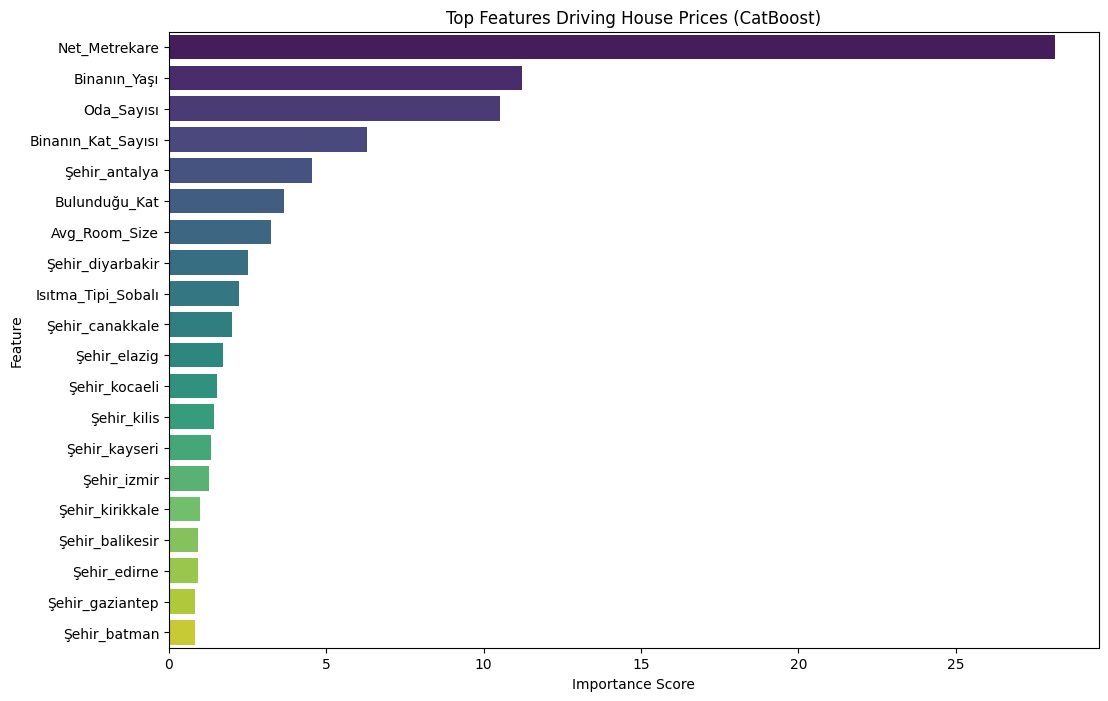

               Feature  Importance
0        Net_Metrekare   28.146064
3         Binanın_Yaşı   11.212721
1           Oda_Sayısı   10.511887
4   Binanın_Kat_Sayısı    6.297946
35       Şehir_antalya    4.556371


In [8]:

# 1. Initialize
# verbose=0 keeps it quiet (CatBoost is very talkative by default)
cb_model = CatBoostRegressor(
    iterations=1000, 
    learning_rate=0.05, 
    depth=6, 
    loss_function='RMSE',
    verbose=0,
    random_state=42
)

# 2. Train
cb_model.fit(X_train, y_train)

# 3. Predict & Evaluate
y_pred_cb = cb_model.predict(X_test)

# Check score
from sklearn.metrics import mean_squared_error
import numpy as np
rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_cb)))
print(f"CatBoost RMSE: {rmse:,.0f}")
# --- CatBoost Feature Importance ---

# 1. Get Importances
# CatBoost makes this easy with the .feature_importances_ attribute
cb_importances = cb_model.feature_importances_
feature_names = X_train.columns 

# 2. Create DataFrame for Plotting
cb_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': cb_importances
})

# 3. Sort by Importance (High to Low)
cb_importance_df = cb_importance_df.sort_values(by='Importance', ascending=False)

# 4. Plot the Top 20 Features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=cb_importance_df.head(20), palette='viridis')
plt.title('Top Features Driving House Prices (CatBoost)')
plt.xlabel('Importance Score')
plt.show()

# Optional: Print the top 5 just to see the numbers
print(cb_importance_df.head(5))

### Getting msot important features to our best model:
* lets rank features by importance to our model.

C:\Users\pc\AppData\Local\Temp\ipykernel_39208\4221716712.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features_xgb, palette='magma')


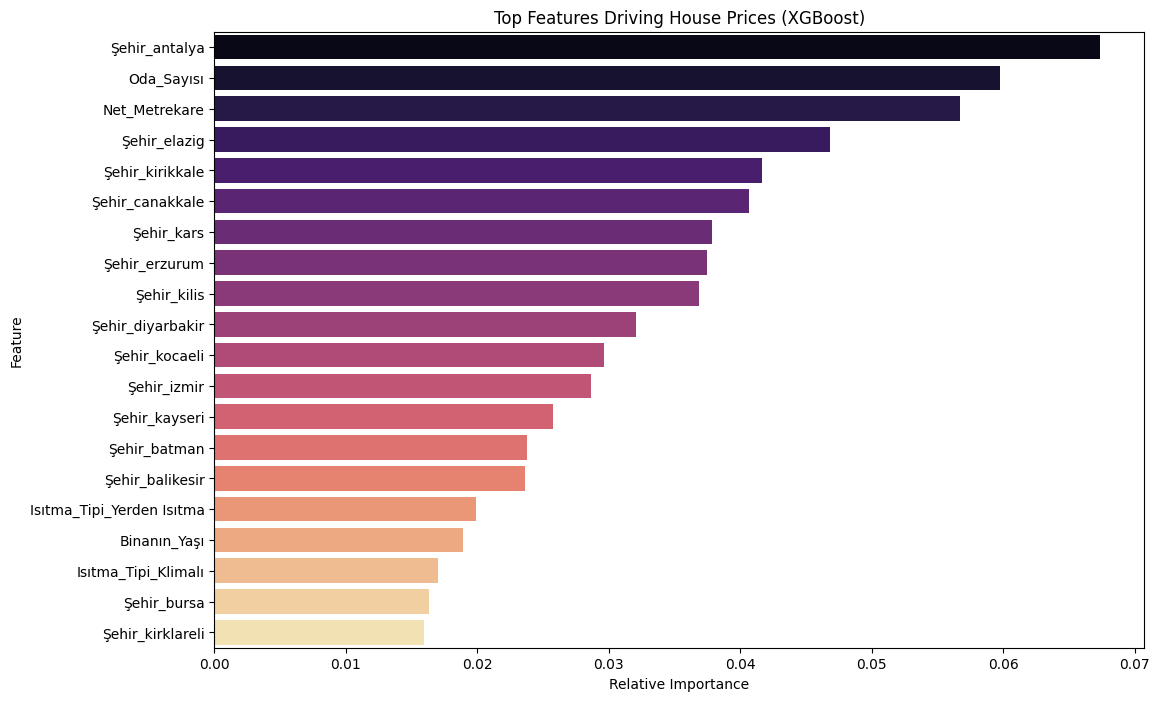

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Get Importances
# XGBoost has a built-in plot_importance function, but making our own is prettier
importances = best_xgb.feature_importances_
feature_names = X.columns # Make sure 'X' is your dataframe of features

# 2. Create DataFrame
xgb_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# 3. Sort and Plot Top 20
top_features_xgb = xgb_importance_df.sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=top_features_xgb, palette='magma')
plt.title('Top Features Driving House Prices (XGBoost)')
plt.xlabel('Relative Importance')
plt.show()

* We can see that location is the most important feature for our model.
* This is expected as location is a strong indicator of house prices in Turkey, especially in last years.
* Being in antalya is a big indicator of house price for our model, which aligns with recent changes in housing market .
* bathroom count is the second most important feature for our model.
* this feature is mos likely masking for other important features such as m2 , but our model is just focusing on this feature for prediction(coorect me if I am wrong).

#### Saving model, scaler, and colums to use in api:


In [10]:
import joblib

# Save model columns
model_columns = list(X.columns)
joblib.dump(model_columns, 'model_columns.pkl')
print(f"Saved model_columns.pkl with {len(model_columns)} columns")

# Save scaler
joblib.dump(scaler, 'scaler.pkl')
print("Saved scaler.pkl")

# Save model
joblib.dump(best_xgb, 'xgb_model.joblib')
print("Saved xgb_model.joblib")

Saved model_columns.pkl with 74 columns
Saved scaler.pkl
Saved xgb_model.joblib


## Final Observations:
* The tree-based XGBoost model improved after tuning because it uses threshold splits that work well even on unscaled data.
* SVR performance likely dropped because the algorithm relies on sensitive distance calculations between data points.
* Since the grid search did not include a scaling pipeline, the SVR optimization prioritized features with larger raw numbers over predictive value.
* Continuous hyperparameters like C and gamma made the SVR model prone to finding a highly specific, complex solution that fit the training data too closely.
* The specific SVR configuration found by the search likely memorized training noise rather than learning general rules, leading to overfitting.
* Unlike the discrete tree depth settings in XGBoost, the complex SVR boundary failed to generalize effectively to the new test set.
* Using the standard statistical range to filter price outliers removed valid high-end luxury properties from the training dataset.
* Because real estate prices are naturally skewed, this strict filter left the model unable to learn how to accurately price expensive homes.
* The method used to fill missing floor data implicitly converted all unknown values to zero.
* Defaulting these values to zero treated unknown units as ground-floor apartments, which typically sell for lower prices than upper floors.
* This imputation strategy likely introduced a systematic downward bias for a significant portion of the housing data.